In [2]:
pip install WordCloud

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 5.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [56]:
import os
import shutil
import tarfile
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [57]:
current_folder = os.getcwd()

dataset = tf.keras.utils.get_file(
    fname ="aclImdb.tar.gz",
    origin ="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    cache_dir=  current_folder,
    extract = True)

In [58]:
dataset_path = os.path.dirname(dataset)
os.listdir(dataset_path)

['aclImdb', 'aclImdb.tar.gz']

In [59]:
dataset_dir = os.path.join(dataset_path, 'aclImdb')
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [60]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

In [61]:
for file in os.listdir(train_dir):
    file_path = os.path.join(train_dir, file)
    if os.path.isfile(file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            first_value = f.readline().strip()
            print(f"{file}: {first_value}")
    else:
        print(f"{file}: {file_path}")

urls_unsup.txt: http://www.imdb.com/title/tt0018515/usercomments
neg: /Users/saninzulphi/Documents/GitHub/LLM/datasets/aclImdb/train/neg
urls_pos.txt: http://www.imdb.com/title/tt0453418/usercomments
unsup: /Users/saninzulphi/Documents/GitHub/LLM/datasets/aclImdb/train/unsup
urls_neg.txt: http://www.imdb.com/title/tt0064354/usercomments
pos: /Users/saninzulphi/Documents/GitHub/LLM/datasets/aclImdb/train/pos
unsupBow.feat: 0 0:8 1:6 3:5 4:2 5:1 7:1 8:5 9:2 10:1 11:2 13:3 16:1 17:1 18:1 19:1 22:3 24:1 26:3 28:1 30:1 31:1 35:2 36:1 39:2 40:1 41:2 46:2 47:1 48:1 52:1 63:1 67:1 68:1 74:1 81:1 83:1 87:1 104:1 105:1 112:1 117:1 131:1 151:1 155:1 170:1 198:1 225:1 226:1 288:2 291:1 320:1 331:1 342:1 364:1 374:1 384:2 385:1 407:1 437:1 441:1 465:1 468:1 470:1 519:1 595:1 615:1 650:1 692:1 851:1 937:1 940:1 1100:1 1264:1 1297:1 1317:1 1514:1 1728:1 1793:1 1948:1 2088:1 2257:1 2358:1 2584:2 2645:1 2735:1 3050:1 4297:1 5385:1 5858:1 7382:1 7767:1 7773:1 9306:1 10413:1 11881:1 15907:1 18613:1 18877

In [62]:
def load_dataset(directory):
    data = {"sentence": [], "sentiment": []}
    for file_name in os.listdir(directory):
        print(file_name)
        if file_name == 'pos':
            positive_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(positive_dir):
                text = os.path.join(positive_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(1)
        elif file_name == 'neg':
            negative_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(negative_dir):
                text = os.path.join(negative_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(0)

    return pd.DataFrame.from_dict(data)

In [63]:
train_df = load_dataset(train_dir)
print(train_df.head())

urls_unsup.txt
neg
urls_pos.txt
unsup
urls_neg.txt
pos
unsupBow.feat
labeledBow.feat
                                            sentence  sentiment
0  Working with one of the best Shakespeare sourc...          0
1  Well...tremors I, the original started off in ...          0
2  Ouch! This one was a bit painful to sit throug...          0
3  I've seen some crappy movies in my life, but t...          0
4  "Carriers" follows the exploits of two guys an...          0


In [64]:
test_dir = os.path.join(dataset_dir,'test')

test_df = load_dataset(test_dir)
print(test_df.head())

neg
urls_pos.txt
urls_neg.txt
pos
labeledBow.feat
                                            sentence  sentiment
0  Alan Rickman & Emma Thompson give good perform...          0
1  I have seen this movie and I did not care for ...          0
2  In Los Angeles, the alcoholic and lazy Hank Ch...          0
3  This film is bundled along with "Gli fumavano ...          0
4  I only comment on really very good films and o...          0


In [65]:
def sample_dataset(df, n_samples):
    return df.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(min(len(x), n_samples)))

n_samples = 1000 
train_df_reduced = sample_dataset(train_df, n_samples)
test_df_reduced = sample_dataset(test_df, n_samples)

print(train_df_reduced.head())

                                                sentence  sentiment
10530  I just didn't get this movie...Was it a musica...          0
9714   This is not a commentary on the actual movie, ...          0
4750   I literally fell asleep 3 times watching this ...          0
2218   This movie is all ultra-lightweight fluff, pre...          0
9598   Undeveloped/unbelievable story line,(by the ti...          0


/var/folders/3c/h3pdj2191bjgl7k8kswt29lw0000gn/T/ipykernel_6484/1719222148.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/3c/h3pdj2191bjgl7k8kswt29lw0000gn/T/ipykernel_6484/1719222148.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [66]:
sentiment_counts = train_df_reduced['sentiment'].value_counts()

fig = px.bar(
    x=['Negative', 'Positive'],
    y=sentiment_counts.values,
    color=sentiment_counts.index,
    color_discrete_sequence=px.colors.qualitative.Dark24,
    title='<b>Sentiment Counts</b>'
)

fig.update_layout(
    title='Sentiment Counts',
    xaxis_title='Sentiment',
    yaxis_title='Counts',
    template='plotly_dark'
)

# Show the bar chart
fig.show()
pyo.plot(fig, filename='Sentiment_Counts.html', auto_open=True)

Python(7590) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


'Sentiment_Counts.html'

In [67]:
def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    text = re.sub(pattern, '', text)
    return text

In [68]:
train_df_reduced['Cleaned_sentence'] = train_df_reduced['sentence'].apply(text_cleaning).tolist()
test_df_reduced['Cleaned_sentence'] = test_df_reduced['sentence'].apply(text_cleaning)

/var/folders/3c/h3pdj2191bjgl7k8kswt29lw0000gn/T/ipykernel_6484/3524044076.py:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [69]:
def generate_wordcloud(text,Title):
    all_text = " ".join(text)
    wordcloud = WordCloud(width=800,
                          height=400,
                          stopwords=set(STOPWORDS),
                          background_color='black').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()

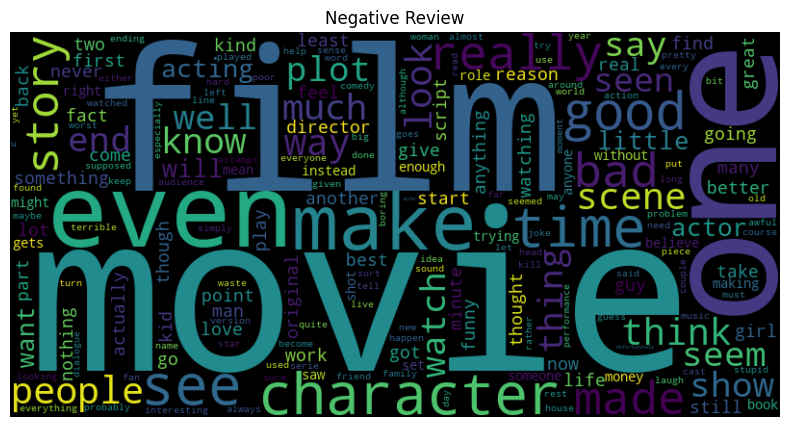

In [ ]:
negative = train_df[train_df['sentiment']==0]['Cleaned_sentence'].tolist()
generate_wordcloud(negative,'Negative Review')

In [73]:
# Training data
#Reviews = "[CLS] " +train_df['Cleaned_sentence'] + "[SEP]"
Reviews = train_df_reduced['Cleaned_sentence']
Target = train_df_reduced['sentiment']

# Test data
#test_reviews =  "[CLS] " +test_df['Cleaned_sentence'] + "[SEP]"
test_reviews = test_df_reduced['Cleaned_sentence']
test_targets = test_df_reduced['sentiment']

In [74]:
x_val, x_test, y_val, y_test = train_test_split(test_reviews,
                                                    test_targets,
                                                    test_size=0.5,
                                                    stratify = test_targets)

In [75]:
#Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [76]:
max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(Reviews.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')


In [78]:
k = 2
print('Training Comments -->>',Reviews[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',Target[k])


Training Comments -->> Ouch This one was a bit painful to sit through It has a cute and amusing premise, but it all goes to hell from there Matthew Modine is almost always pedestrian and annoying, and he does not disappoint in this one Deborah Kara Unger and John Neville turned in surprisingly decent performances Alan Bates and Jennifer Tilly, among others, played it way over the top I know that's the way the parts were written, and it's hard to blame actors, when the script and director have them do such schlock If you're going to have outrageous characters, that's OK, but you gotta have good material to make it work It didn't here Run away screaming from this movie if at all possible

Input Ids -->>
 tf.Tensor(
[  101  1045  6719  3062  6680  1017  2335  3666  2023  3185  4379  1010
  2009  1005  1055  8101  1998  2008  3138  1037  3056  9273  3388  2000
  2022  4699  2030  2025  2021  2023  3185 23651  2151  8803  1997  2146
 14017 22360 15549  2229  1998  2054  2025  1010  2008  20

In [79]:
# Intialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
print(tf.__version__)


2.16.1


In [81]:
# Create the optimizer
optimizer = 'adam'  # Pass the optimizer as a string

# Define the loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Define the metric
metric = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

# Assume model is already defined, for example:
# model = tf.keras.models.Sequential([...])

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


In [83]:
# Step 5: Train the model
history = model.fit(
	[X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
	Target,
	validation_data=(
	[X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
	batch_size=16,
	epochs=3
)


Epoch 1/3
125/125 [==============================] - 628s 5s/step - loss: 0.7265 - accuracy: 0.5025 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 2/3
125/125 [==============================] - 622s 5s/step - loss: 0.7307 - accuracy: 0.5095 - val_loss: 0.8682 - val_accuracy: 0.5000
Epoch 3/3
125/125 [==============================] - 604s 5s/step - loss: 0.7403 - accuracy: 0.4945 - val_loss: 0.7357 - val_accuracy: 0.5000


In [84]:
#Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
	y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')


32/32 [==============================] - 78s 2s/step - loss: 0.7357 - accuracy: 0.5000
Test loss: 0.7357102036476135, Test accuracy: 0.5


In [85]:
path = '/Users/saninzulphi/Documents/GitHub/LLM/'
# Save tokenizer
tokenizer.save_pretrained(path +'/Tokenizer')

# Save model
model.save_pretrained(path +'/Model')


In [86]:
# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer')

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model')


Some layers from the model checkpoint at /Users/saninzulphi/Documents/GitHub/LLM//Model were not used when initializing TFBertForSequenceClassification: ['dropout_113']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /Users/saninzulphi/Documents/GitHub/LLM//Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [87]:
pred = bert_model.predict(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

# pred is of type TFSequenceClassifierOutput
logits = pred.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()

label = {
	1: 'positive',
	0: 'Negative'
}

# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]

print('Predicted Label :', pred_labels[:10])
print('Actual Label :', Actual[:10])


32/32 [==============================] - 83s 2s/step
Predicted Label : ['Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative']
Actual Label : ['Negative', 'positive', 'Negative', 'Negative', 'Negative', 'Negative', 'positive', 'Negative', 'positive', 'positive']


In [88]:
print("Classification Report: \n", classification_report(Actual, pred_labels))


Classification Report: 
               precision    recall  f1-score   support

    Negative       0.50      1.00      0.67       500
    positive       0.00      0.00      0.00       500

    accuracy                           0.50      1000
   macro avg       0.25      0.50      0.33      1000
weighted avg       0.25      0.50      0.33      1000



/Users/saninzulphi/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/saninzulphi/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/saninzulphi/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

